In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-77.90174759231485
SNR Threshold: 27


Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


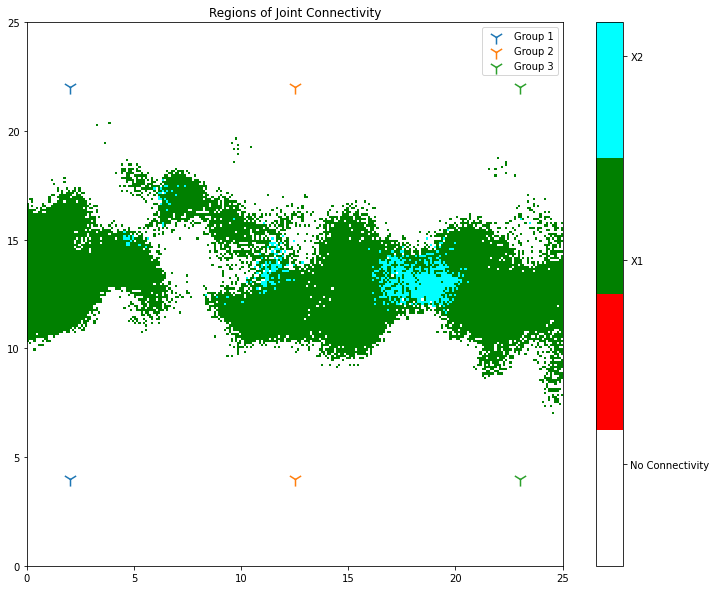

In [3]:
#Setup the system:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#8 remote stations
qBase = np.array([[2,4],[2,22],
                 [12.5,4],[12.5,22],
                 [23,4],[23,22]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 25
x_min = 0
y_max = 25
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)

# #now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(GAMMA_TH) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 1*cfs[2]*cfs[3]; r3 = 1*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), marker='1', s=200)
plt.legend()    
plt.show()

In [4]:
#Create the predicted channel
pct_sample = 0.005
n_samples = int(pct_sample*(x_max - x_min)*(y_max - y_min)*res**2)
print('Drawing %d samples from each region'%(n_samples))
pcs = []
for cc in ccs:
    xs, vals = cc.sampleChannel(n_samples)
    pcs.append(CC.PredictedChannel(cc.cp, cc.region, res, xs, vals))
    print('Completed PredictedChannel %d'%(len(pcs)))
#avoid collisions when saving this off
pcs3 = pcs
%store pcs3

Drawing 312 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
Completed PredictedChannel 3
Completed PredictedChannel 4
Completed PredictedChannel 5
Completed PredictedChannel 6
Stored 'pcs3' (list)


In [5]:
#%store -r pcs3
#pcs = pcs3

In [6]:
#now display the regions so we know if this is going to work for us
color_array=['white', 'blue', 'red', 'green', 'cyan']
#plot the connectivity fields
pfs = [pc.getPConField(GAMMA_TH) for pc in pcs]

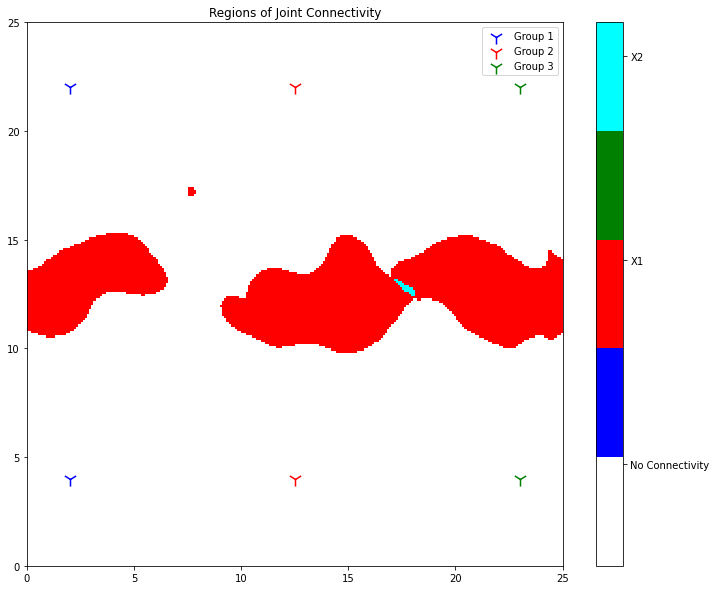

In [7]:
p_th = 0.7
for pc in pcs:
    pc.setPth(p_th)

r1 = 1*(pfs[0]*pfs[1]>p_th); r2 = 1*(pfs[2]*pfs[3]>p_th); r3 = 1*(pfs[4]*pfs[5]>p_th);
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [8]:
from importlib import reload 
reload(dtr)
# reload(MRP)
# reload(PS)
reload(PC)

<module 'pointcloud' from '/home/win/dev/CommMotionPlanning/python/touring_relay/../geometry/pointcloud.py'>

In [9]:
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)

p3 = [0.2, 0.1, 0.02]
pis = []
Xs = []
Ws =[]

#Naive Variables
npis = []
nXs = []
nWs =[]

#
all_els = []

els = np.ones(len(pcs)//2)/(beta*len(pcs))
sys = dtr.DTR(pcs, els, beta, th=GAMMA_TH)
for i in range(len(p3)):
    #make it easy to ensure stability by givein arrivals in terms of beta
    els = np.array([0.2/beta, 0.2/beta, p3[i]/beta])
    all_els.append(els)
    sys.ps.Ls = els
    W, pi, X = sys.optimize(x_opt_method=3, do_plot = False)
    pis.append(pi)
    Xs.append(X)
    Ws.append(W)
    nW, npi, nX = sys.naive_policy()
    npis.append(npi)
    nXs.append(nX)
    nWs.append(nW)
    print("============================================================")
    print("============================================================")
    print('Optimized:')
    print('\tPi: '+str(pi)+'\n\tRelay Positions: '+ str(X)+'\n\tWaiting Time: '+str(W))
    print('Naive:')
    print('\tPi: '+str(npi)+'\n\tRelay Positions: '+ str(nX)+'\n\tWaiting Time: '+str(nW))
    print("============================================================")
    print("============================================================")

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
7 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
11 total subregions
Optimized Policy Waiting Time: 39.1537
Academic license - for non-commercial use only - expires 2021-08-20
Using license file /home/win/gurobi.lic
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 155 rows, 37 columns and 456 nonzeros
Model fingerprint: 0xf646ed3d
Model has 3 quadratic constraints
Variable types: 9 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+04]
  QMatrix range    [1e+00, 

     0     0    0.00019    0   19          -    0.00019      -     -    0s
     0     0    0.00022    0   15          -    0.00022      -     -    0s
     0     0    0.00023    0   16          -    0.00023      -     -    0s
     0     0    0.00023    0   19          -    0.00023      -     -    0s
     0     0    0.00023    0   19          -    0.00023      -     -    0s
     0     0    0.00023    0   16          -    0.00023      -     -    0s
     0     0    0.00024    0   16          -    0.00024      -     -    0s
     0     0    0.00024    0   17          -    0.00024      -     -    0s
     0     0    0.00024    0   16          -    0.00024      -     -    0s
     0     0    0.00024    0   19          -    0.00024      -     -    0s
     0     0    0.00436    0   20          -    0.00436      -     -    0s
H    0     0                       0.6776532    0.00436  99.4%     -    0s
     0     2    0.02900    0   20    0.67765    0.02900  95.7%     -    0s
H    3     3             

     0     0    0.00006    0   16          -    0.00006      -     -    0s
     0     0    0.00006    0   18          -    0.00006      -     -    0s
     0     0    0.00006    0   21          -    0.00006      -     -    0s
     0     0    0.00006    0   20          -    0.00006      -     -    0s
     0     0    0.00007    0   17          -    0.00007      -     -    0s
     0     0    0.00008    0   16          -    0.00008      -     -    0s
     0     0    0.00008    0   18          -    0.00008      -     -    0s
     0     0    0.00008    0   16          -    0.00008      -     -    0s
     0     0    0.00008    0   14          -    0.00008      -     -    0s
     0     0    0.00009    0   14          -    0.00009      -     -    0s
     0     0    0.00009    0   16          -    0.00009      -     -    0s
     0     0    0.00009    0   16          -    0.00009      -     -    0s
     0     0    0.00009    0   14          -    0.00009      -     -    0s
     0     0    0.00009  

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 155 rows, 37 columns and 456 nonzeros
Model fingerprint: 0x3278896b
Model has 3 quadratic constraints
Variable types: 9 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [3e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 18 rows and 0 columns
Presolve time: 0.04s
Presolved: 191 rows, 52 columns, 970 nonzeros
Presolved model has 15 bilinear constraint(s)
Variable types: 24 continuous, 28 integer (28 binary)

Root relaxation: objective 0.000000e+00, 41 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

* 2518   251              85       0.0729034    0.05687  22.0%   5.1    2s
* 2519   236              84       0.0728995    0.05687  22.0%   5.1    2s
* 4551   327              67       0.0708798    0.05709  19.5%   4.7    3s
* 5974   418              69       0.0706779    0.05734  18.9%   4.8    3s
* 5977   419              71       0.0706779    0.05734  18.9%   4.8    3s
* 7713   554              69       0.0698002    0.05752  17.6%   4.9    4s
* 7847   538              77       0.0685212    0.05752  16.1%   4.9    4s
* 7848   537              77       0.0684435    0.05752  16.0%   4.9    4s
H 7976   549                       0.0684212    0.05753  15.9%   4.9    4s
* 8325   518              82       0.0648034    0.05756  11.2%   4.9    4s
  8445   526    0.05774   44    6    0.06480    0.05757  11.2%   4.9    5s
*10214   591              65       0.0647547    0.05778  10.8%   4.8    5s
*10215   590              65       0.0647524    0.05778  10.8%   4.8    5s
*11664   710             

     0     0    0.00003    0   18          -    0.00003      -     -    0s
     0     0    0.00004    0   18          -    0.00004      -     -    0s
     0     0    0.00005    0   18          -    0.00005      -     -    0s
     0     0    0.00005    0   20          -    0.00005      -     -    0s
     0     0    0.00005    0   19          -    0.00005      -     -    0s
     0     0    0.00005    0   18          -    0.00005      -     -    0s
     0     0    0.00005    0   19          -    0.00005      -     -    0s
     0     0    0.00005    0   19          -    0.00005      -     -    0s
     0     0    0.00005    0   20          -    0.00005      -     -    0s
     0     0    0.00005    0   16          -    0.00005      -     -    0s
H    0     0                       1.2613959    0.00005   100%     -    0s
     0     2    0.00005    0   16    1.26140    0.00005   100%     -    0s
H   11    11                       0.6223249    0.00005   100%  17.8    0s
H   27    17             

*  447   126              57       0.1064396    0.00019   100%   4.4    0s
*  789   166              72       0.0865819    0.01790  79.3%   4.5    1s
*  914   135              70       0.0741510    0.01790  75.9%   4.2    1s
* 2054   218              76       0.0720423    0.04430  38.5%   4.5    2s
* 2719   306              70       0.0696851    0.04460  36.0%   4.2    2s
* 3723   408              95       0.0680101    0.04480  34.1%   4.0    2s
* 3727   410              97       0.0680066    0.04480  34.1%   4.0    2s
* 3728   409              97       0.0680060    0.04480  34.1%   4.0    2s
* 3730   409              97       0.0679991    0.04480  34.1%   4.0    2s
* 3731   408              97       0.0679983    0.04480  34.1%   4.0    2s
* 3732   407              95       0.0679975    0.04480  34.1%   4.0    2s
* 3813   402              64       0.0667412    0.04483  32.8%   4.0    2s
* 3814   401              64       0.0667384    0.04483  32.8%   4.0    2s
* 4219   434             

H    0     0                       1.6903398    0.00005   100%     -    0s
H    0     0                       1.5843400    0.00005   100%     -    0s
     0     2    0.00005    0   16    1.58434    0.00005   100%     -    0s
H   19    13                       0.7792323    0.00005   100%  14.0    0s
H   30    18                       0.7720117    0.00005   100%  11.4    0s
*   90    42              50       0.6752480    0.00005   100%   6.2    0s
*  189    61              39       0.4201549    0.00005   100%   5.6    1s
*  341    94              51       0.2421843    0.00021   100%   5.2    1s
H  598   184                       0.1222873    0.01330  89.1%   5.6    1s
*  807   155              57       0.1201111    0.01844  84.6%   5.4    1s
* 2182   192              47       0.1068895    0.04744  55.6%   5.4    2s
* 2183   191              47       0.1068319    0.04744  55.6%   5.4    2s
* 2727   278              60       0.0938876    0.04774  49.2%   5.2    3s
H 2991   258             

H    0     0                      25.7009427    0.00000   100%     -    0s
     0     2    0.00000    0   18   25.70094    0.00000   100%     -    0s
H   11    11                      21.2239155    0.00000   100%  11.5    0s
H  188   116                      21.0575262    0.00000   100%   4.9    0s
*  384   146              39      21.0439023    4.84574  77.0%   4.3    0s
*  957   193              42      21.0018453    9.29888  55.7%   5.1    1s
* 1345   192              51      21.0011113   11.73650  44.1%   4.9    1s
* 1346   191              51      21.0011113   11.73650  44.1%   4.9    1s
* 2771   280              82      21.0009527   19.26108  8.28%   4.3    2s
* 2772   279              82      21.0009527   19.26108  8.28%   4.3    2s
* 5335   684             102      21.0009520   20.50243  2.37%   3.5    3s
* 5337   676             101      21.0009520   20.50243  2.37%   3.5    3s
* 8715  1145              71      21.0009518   20.88606  0.55%   3.1    4s
* 8723  1145             

Coefficient statistics:
  Matrix range     [9e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [3e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 18 rows and 0 columns
Presolve time: 0.03s
Presolved: 191 rows, 52 columns, 970 nonzeros
Presolved model has 15 bilinear constraint(s)
Variable types: 24 continuous, 28 integer (28 binary)

Root relaxation: objective 0.000000e+00, 39 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   12          -    0.00000      -     -    0s
     0     0    0.00000    0   13          -    0.00000      -     -    0s
     0     0    0.00000    0   13          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
   

* 8715  1145              71      21.0009518   20.88606  0.55%   3.1    5s
* 8723  1145              74      21.0009518   20.88606  0.55%   3.1    5s
* 8724  1142              75      21.0009517   20.88606  0.55%   3.1    5s
* 8727  1143              76      21.0009517   20.88606  0.55%   3.1    5s
* 8728  1142              77      21.0009517   20.88606  0.55%   3.1    5s
* 8731  1143              78      21.0009517   20.88606  0.55%   3.1    5s
* 8732  1142              79      21.0009516   20.88606  0.55%   3.1    5s
* 8734  1138              80      21.0009512   20.88606  0.55%   3.1    5s
*18524  3012              67      21.0009507   20.98390  0.08%   2.4    9s
 19489  3181   21.00014   47   12   21.00095   20.98573  0.07%   2.4   10s
 30872  4764   21.00082   53    7   21.00095   20.99551  0.03%   2.2   15s
 38775  6169   21.00095   63    4   21.00095   20.99735  0.02%   2.1   20s
 50444  7596 infeasible   50        21.00095   20.99879  0.01%   2.0   25s

Cutting planes:
  PSD: 7

Best objective 7.055342314264e-01, best bound 7.055041236810e-01, gap 0.0043%
Transition probabilities:  [0.20995048 0.75852098 0.03152854]
Points:  [[ 6.40086224 12.80344898]
 [ 9.1        12.1       ]
 [17.         13.3       ]]
Optimized Location Waiting Time: 9.7955
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 155 rows, 37 columns and 456 nonzeros
Model fingerprint: 0x215b0f37
Model has 3 quadratic constraints
Variable types: 9 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [7e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 18 rows and 0 columns
Presolve time: 0.03s
Presolved: 191 rows, 52 columns, 970 nonzeros
Presolved model has 15 bilinear con

In [17]:
for i in range(len(p3)):
    print("============================================================")
    print("============================================================")
    print('Arrival Rates: ' + str(all_els[i]))
    print('Routing Policy (pi)')
    print('\tOptimal: '+str(pis[i])+'\tNaive: ' + str(npis[i]))
    print('Waiting Time')
    print('\tOptimal: %.2f\tNaive: %.2f\tDifference: %.2f'%(Ws[i], nWs[i], nWs[i] - Ws[i]) )
    
print("============================================================")
print("============================================================")

Arrival Rates: [2.4 2.4 2.4]
Routing Policy (pi)
	Optimal: [0.00465674 0.50225753 0.49308573]	Naive: [0.33333333 0.33333333 0.33333333]
Waiting Time
	Optimal: 16.51	Naive: 28.46	Difference: 11.95
Arrival Rates: [2.4 2.4 1.2]
Routing Policy (pi)
	Optimal: [0.2766331  0.62861321 0.09475368]	Naive: [0.4 0.4 0.2]
Waiting Time
	Optimal: 17.67	Naive: 25.01	Difference: 7.34
Arrival Rates: [2.4  2.4  0.24]
Routing Policy (pi)
	Optimal: [0.20964918 0.75885867 0.03149215]	Naive: [0.47619048 0.47619048 0.04761905]
Waiting Time
	Optimal: 9.80	Naive: 22.60	Difference: 12.80


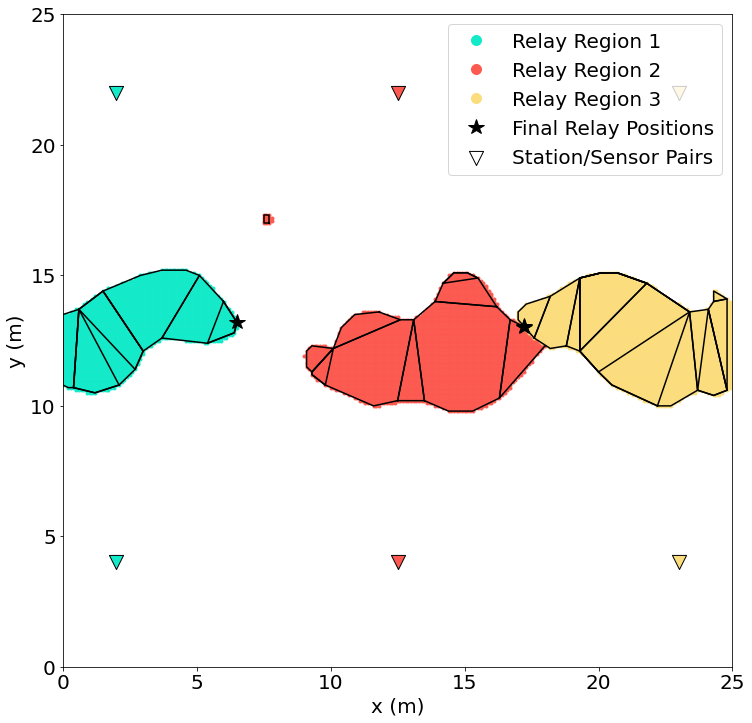

In [16]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')
pod_colors = []
x=Xs[0]
plt.plot(x[:,0], x[:,1], '*k', markersize=16, label='Final Relay Positions')
plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=fs)
plt.ylabel('y (m)', fontsize=fs)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_three_lines_%d_pth_%.2f_gammath_%d.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

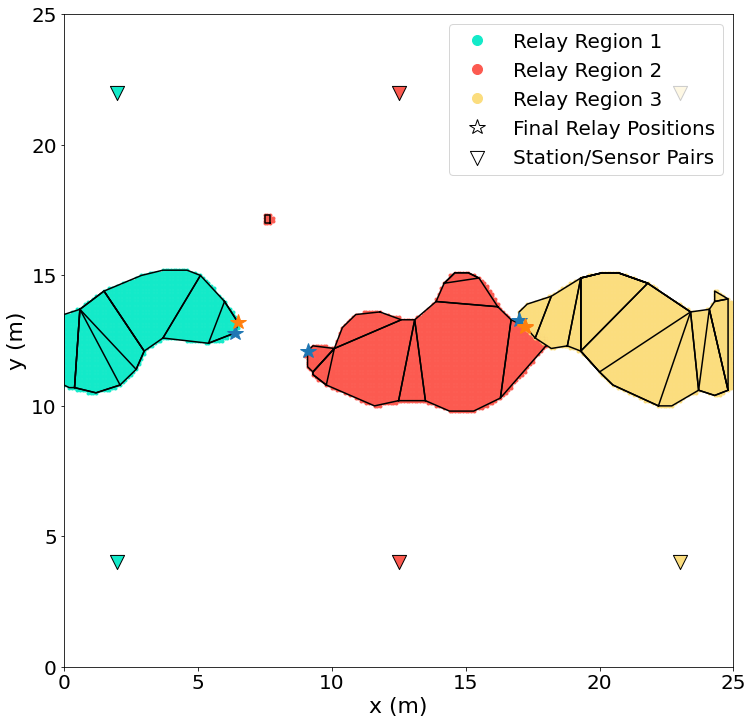

In [15]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')


x=Xs[2]
plt.plot(x[:,0], x[:,1], '*', markersize=16)
x= Xs[0]
plt.plot(x[:,0], x[:,1], '*', markersize=16)
#for the legend
plt.plot([-100], [100], '*', color='w', markeredgecolor='k', markersize=16, label='Final Relay Positions')
#ax = plt.gca()
#ax.annotate('')

plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=22)
plt.ylabel('y (m)', fontsize=22)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_three_lines_%d_pth_%.2f_gammath_%d_alt.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

In [ ]:
print(np.array([0.2/beta, 0.2/beta, p3[0]/beta]))
print(np.array([0.2/beta, 0.2/beta, p3[2]/beta]))

In [ ]:
beta